In [21]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import seaborn as sns
import numpy as np

from src import datasets, metrics

In [22]:
import tomllib

datadir = Path('../data')
configfile = Path("config.toml")

with configfile.open('rb') as f:
    config = tomllib.load(f)
print(config)

{'ptb': 'heart', 'arrhythmia': 'heart_big'}


In [23]:
# data paths
trainfile = datadir / (config['arrhythmia'] + '_train.parq')
testfile = datadir / (config['arrhythmia'] + '_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_train.parq'),
 PosixPath('../data/heart_big_test.parq'))

In [24]:
train_df = pd.read_parquet(trainfile)
test_df = pd.read_parquet(testfile)

In [25]:
norm_train_df = train_df[train_df['target'] == 0]
anom_train_df = train_df[train_df['target'] != 0]
norm_test_df = test_df[test_df['target'] == 0]
anom_test_df = test_df[test_df['target'] != 0]

In [26]:
# create two separate datasets for normal and anomalous data

# norm_test_df.to_parquet(datadir / 'heart_big_norm_train.parq')
# anom_test_df.to_parquet(datadir / 'heart_big_anom_train.parq')

# norm_test_df.to_parquet(datadir / 'heart_big_norm_test.parq')
# anom_test_df.to_parquet(datadir / 'heart_big_anom_test.parq')



In [27]:
trainfile = datadir / (config['arrhythmia'] + '_norm_train.parq')
testfile = datadir / (config['arrhythmia'] + '_norm_test.parq')
trainfile, testfile

(PosixPath('../data/heart_big_norm_train.parq'),
 PosixPath('../data/heart_big_norm_test.parq'))

In [28]:
#loading the datasets 
traindataset = datasets.HeartDataset1D(trainfile, target="target")
testdataset = datasets.HeartDataset1D(testfile, target="target")
traindataset, testdataset

# moving to mps device crashes the jupyter kernel

(Heartdataset (len 18118), Heartdataset (len 18118))

In [29]:
# creating the datastreamers
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
len(trainstreamer), len(teststreamer)

(566, 566)

In [30]:
# shape = (16, 12)
# traindataset = datasets.HeartDataset2D(trainfile, target="target", shape=shape)
# testdataset = datasets.HeartDataset2D(testfile, target="target", shape=shape)
# traindataset, testdataset

In [31]:
# trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=32)
# teststreamer = BaseDatastreamer(testdataset, preprocessor = BasePreprocessor(), batchsize=32)
# len(trainstreamer), len(teststreamer)

In [32]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([32, 192, 1]), torch.Size([32]))

In [33]:
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [34]:
import mlflow
mlflow.set_tracking_uri("sqlite:///mads_exam.db")
mlflow.set_experiment("Autoencoder model")

<Experiment: artifact_location='/Users/francesca/code_repo/MADS-exam-25/notebooks/mlruns/5', creation_time=1737202180165, experiment_id='5', last_update_time=1737202180165, lifecycle_stage='active', name='Autoencoder model', tags={}>

In [35]:
from typing import Iterator
from pydantic import BaseModel
from mads_datasets.base import BaseDatastreamer
class VAEstreamer(BaseDatastreamer):
    def stream(self) -> Iterator:
        while True:
            if self.index > (self.size - self.batchsize):
                self.reset_index()
            batch = self.batchloop()
            # we throw away the Y
            X_, _ = zip(*batch)  # noqa N806
            X = torch.stack(X_)  # noqa N806
            # change the channel to channel-last
            X = torch.moveaxis(X, 1, 2)  # noqa N806
            # and yield X, X
            yield X, X

class VAESettings(BaseModel):
    data_dir: Path = Path("data")
    h1: int = 192
    h2: int = 100
    insize: int = 2
    latent: int = 2
    batchsize: int = 32
    epochs: int = 10
    modelname: Path = Path("vaemodel.pt")
    modeldir: Path = Path("models")
    imgpath: Path = Path("img")
    samplesize: int = 512

In [36]:
from mltrainer import ReportTypes, Trainer, TrainerSettings, vae
presets = VAESettings()
print(presets)
trainstreamer = VAEstreamer(traindataset, batchsize=presets.batchsize).stream()
teststreamer = VAEstreamer(testdataset, batchsize=32).stream()
#print(next(trainstreamer))
X1, X2 = next(trainstreamer)
X1.shape, X2.shape

data_dir=PosixPath('data') h1=192 h2=100 insize=2 latent=2 batchsize=32 epochs=10 modelname=PosixPath('vaemodel.pt') modeldir=PosixPath('models') imgpath=PosixPath('img') samplesize=512


(torch.Size([32, 1, 192]), torch.Size([32, 1, 192]))

In [37]:

config = presets.model_dump()
encoder = vae.Encoder(config)
print(encoder)
decoder = vae.Decoder(config)
print(decoder)
latent = encoder(x)
latent = latent.view(32, 1, 16, 12)
print(latent.shape)
x = decoder(latent)
lossfn = ReconstructionLoss()
loss = lossfn(x, y)

Encoder(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (encode): Sequential(
    (0): Linear(in_features=2, out_features=192, bias=True)
    (1): ReLU()
    (2): Linear(in_features=192, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=2, bias=True)
  )
)
Decoder(
  (decode): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=192, bias=True)
    (3): ReLU()
    (4): Linear(in_features=192, out_features=2, bias=True)
  )
)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x192 and 2x192)

In [38]:
import torch
import torch.nn as nn

class ReconstructionLoss(nn.Module):
    def __init__(self):
        super(ReconstructionLoss, self).__init__()

    def forward(self, yhat, y):
        # Ensure yhat and y have the same shape
        assert yhat.shape == y.shape, f"Shape mismatch: yhat {yhat.shape}, y {y.shape}"

        # Compute squared error
        sqe = (y - yhat) ** 2
        
        # Sum over batch and spatial dimensions (height, width, channels)
        summed = sqe.sum(dim=(1, 2))  # Summing over batch, channel, height, and width
        return summed.mean()  # Return the mean squared error over the batch


class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.flatten = nn.Flatten(start_dim=1, end_dim=-1)  # Flatten (32, 1, 16, 12) -> (32, 192)
        self.encode = nn.Sequential(
            nn.Linear(192, 100),  # Flattened input size is 192
            nn.ReLU(),
            nn.Linear(100, 2)  # Output latent vector of size 2
        )

    def forward(self, x):
        x = self.flatten(x)  # Flatten input to [batch_size, 192]
        x = self.encode(x)   # [batch_size, 2] (latent vector)
        return x


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.decode = nn.Sequential(
            nn.Linear(2, 100),  # Latent vector size is 2 -> expand to 100
            nn.ReLU(),
            nn.Linear(100, 192),  # Expand to 192
            nn.ReLU(),
            nn.Linear(192, 192)  # Expand to 192 for reshaping
        )
        
    def forward(self, x):
        x = self.decode(x)  # [batch_size, 192]
        x = x.view(-1, 1, 192)  # Reshape to [batch_size, 1, 16, 12]
        return x


# Instantiate the encoder and decoder
encoder = Encoder()
decoder = Decoder()

# Pass through the encoder
latent = encoder(X1)  # Latent vector of shape [32, 2]

# Pass through the decoder
reconstructed = decoder(latent)  # Reconstructed shape should be [32, 1, 16, 12]
print(reconstructed.shape)  # Should print torch.Size([32, 1, 16, 12])
lossfn = ReconstructionLoss()
print(X1.shape)
loss = lossfn(X1, reconstructed)
print(loss)

torch.Size([32, 1, 192])
torch.Size([32, 1, 192])
tensor(16.7083, grad_fn=<MeanBackward0>)


In [39]:
from typing import Dict
class Encoder(nn.Module):
    """encoder"""

    def __init__(self, config: Dict) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.encode = nn.Sequential(
            nn.Linear(config["insize"], config["h1"]),
            nn.ReLU(),
            nn.Linear(config["h1"], config["h2"]),
            nn.ReLU(),
            nn.Linear(config["h2"], config["latent"]),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.flatten(x)
        latent = self.encode(x)
        return latent


class Decoder(nn.Module):
    def __init__(self, config: Dict) -> None:
        super().__init__()
        self.decode = nn.Sequential(
            nn.Linear(config["latent"], config["h2"]),
            nn.ReLU(),
            nn.Linear(config["h2"], config["h1"]),
            nn.ReLU(),
            nn.Linear(config["h1"], config["insize"]),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.decode(x)
        x = x.reshape((-1, 28, 28, 1))
        return x


class AutoEncoder(nn.Module):
    def __init__(self, config: Dict) -> None:
        super().__init__()
        self.encoder = Encoder(config)
        self.decoder = Decoder(config)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        latent = self.encoder(x)
        x = self.decoder(latent)
        return x

In [40]:
#from src import models
#config Autoencoder
config = {
    "insize": 192,
    "h1": 100,  
    "h2": 40,
    "latent": 2,
    
}
autoencoder = AutoEncoder(config)

In [41]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=2,
        metrics=[accuracy, f1micro, f1macro, precision, recall, loss_fn],
        logdir="logs/heartAE",
        train_steps=len(list(trainstreamer))//5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(list(teststreamer))//5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "Autoencoder")
    mlflow.set_tag("dataset", "heart_big")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=autoencoder,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

    #htop om de gpu te zien
    # dimensie transformer reduceren

KeyboardInterrupt: 

In [ ]:
modelpath = modeldir / "vaemodel.pt"

torch.save(autoencoder, modelpath)

In [ ]:
def predict(model, streamer):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for x, y in next(teststreamer.stream()):
      seq_true = y.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [ ]:
modelpath = presets.modeldir / presets.modelname
model = torch.load(modelpath)


In [ ]:
_, losses = predict(model, trainstreamer)

sns.distplot(losses, bins=50, kde=True);

In [28]:
#from src import models
#config GRU
config = {
    "input": 1,
    "hidden": 256,  # updated key
    "dropout": 0.1,
    "output": 5,
    "num_layers": 2,
}
model = GRUmodel(config)

{'input': 1, 'hidden': 256, 'dropout': 0.1, 'output': 5, 'num_layers': 2}


- Model GRU:

Hyperparameters:
- 256 hidden units
- 4 layers

In [31]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart2D",
        train_steps=len(trainstreamer) // 5, #met 5 epochs heeft het een keer de hele dataset gezien
        valid_steps=len(teststreamer) // 5,
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    # modify the tags when you change them!
    mlflow.set_tag("model", "GRU")
    mlflow.set_tag("dataset", "heart_big")
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")

    mlflow.log_params(config)
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=teststreamer.stream(),
        scheduler=None,
        )
    trainer.loop()

    #htop om de gpu te zien
    # dimensie transformer reduceren

2025-01-16 22:20:10.542 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart2D/20250116-222010
100%|██████████| 547/547 [01:05<00:00,  8.31it/s]
2025-01-16 22:21:22.347 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.5913 test 0.4227 metric ['0.8750', '0.8750', '0.4500', '0.8750', '0.4548']
100%|██████████| 547/547 [01:07<00:00,  8.12it/s]
2025-01-16 22:22:35.683 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.4105 test 0.3516 metric ['0.8994', '0.8994', '0.5772', '0.8994', '0.5830']
100%|██████████| 547/547 [01:07<00:00,  8.10it/s]
2025-01-16 22:23:49.196 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3290 test 0.3067 metric ['0.9251', '0.9251', '0.6858', '0.9251', '0.7039']
100%|██████████| 547/547 [01:49<00:00,  5.01it/s]
2025-01-16 22:25:44.453 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2661 test 0.2121 metric ['0.9446', '0.9446', '0.7358', '0.9446', '0.7440']
100%|██████████| 547/547 [01:09<00:00,  7.92it

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

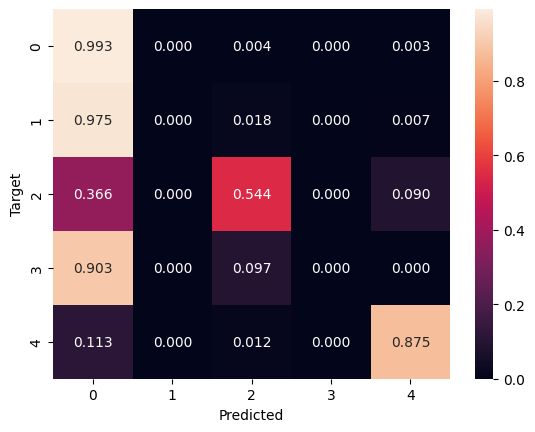

In [32]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

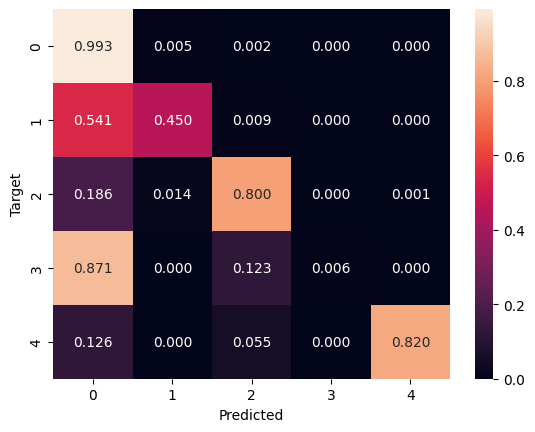

In [27]:
y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

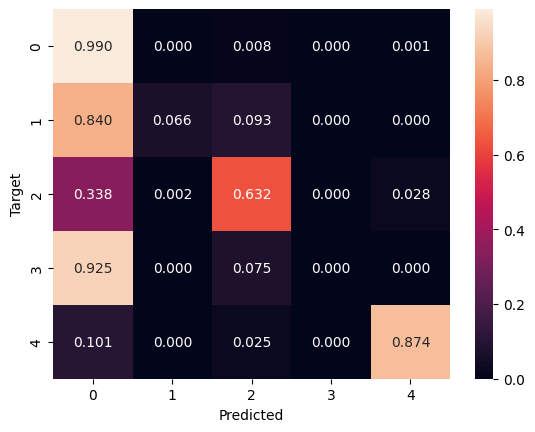

In [22]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

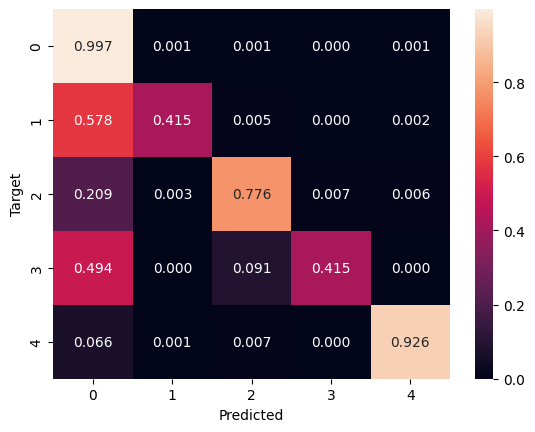

In [27]:
import seaborn as sns
import numpy as np

y_true = []
y_pred = []

testdata = teststreamer.stream()
for _ in range(len(teststreamer)):
    X, y = next(testdata)
    yhat = model(X)
    yhat = yhat.argmax(dim=1) # we get the one with the highest probability
    y_pred.append(yhat.cpu().tolist())
    y_true.append(y.cpu().tolist())

yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm = cfm / np.sum(cfm, axis=1, keepdims=True)

plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")